### 必要なパッケージのインポート

In [1]:
!pip install -U pandas==1.1.5
!pip install -U matplotlib==3.3.4
!pip install -U opencv-python==4.4.0.46
!pip install -U tqdm==4.64.0

import sys
sys.path.append('/home/user/.local/lib/python3.6/site-packages')

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
from math import sin, cos, pi
import cv2
from tqdm.notebook import tqdm

from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model, load_model
from keras.layers import Activation, Convolution2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Conv2D,MaxPool2D, ZeroPadding2D
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 9.5 MB 5.1 MB/s eta 0:00:01
     |████████████████████████████████| 503 kB 30.7 MB/s eta 0:00:01
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 11.5 MB 4.3 MB/s eta 0:00:01
     |████████████████████████████████| 3.1 MB 3.8 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 4.1 MB/s eta 0:00:01
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 49.5 MB 8.0 MB/s eta 0:00:01     |██████████████████▍             | 28.5 MB 4.3 MB/s eta 0:00:05
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 78 kB 1.9 MB/s eta 0:00:011
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


### オーグメンテーションとハイパーパラメータの設定
様々なオーグメンテーションの選択肢を試す

In [2]:
horizontal_flip = False
rotation_augmentation = True
brightness_augmentation = True
shift_augmentation = True
random_noise_augmentation = True

include_unclean_data = True    # キーポイントの値が欠損しているサンプルを含めるかどうか。ただし、欠損値は後でPandasの'ffill'を使って埋められることに注意してください。
sample_image_index = 20    # 様々な拡張機能を可視化するために使用されるサンプルトレイン画像のインデックス

rotation_angles = [12]    # 回転角度（度）（時計回り、反時計回りの回転を含む
pixel_shifts = [12]    # 水平・垂直方向のシフト量（ピクセル）（4隅からのシフトを含む

NUM_EPOCHS = 80
BATCH_SIZE = 64

### Pandas DataFrameへの入力の読み込み

In [3]:
%%time

train_file = 'data/training.csv'
test_file = 'data/test.csv'
idlookup_file = 'data/IdLookupTable.csv'
train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)
idlookup_data = pd.read_csv(idlookup_file)

CPU times: user 1.92 s, sys: 188 ms, total: 2.11 s
Wall time: 2.12 s


顔のキーポイントを画像でプロットする機能

In [4]:
def plot_sample(image, keypoint, axis, title):
    image = image.reshape(96,96)
    axis.imshow(image, cmap='gray')
    axis.scatter(keypoint[0::2], keypoint[1::2], marker='x', s=20)
    plt.title(title)

### データの探索

In [5]:
train_data.head().T

,0,1,2,3,4
left_eye_center_x,66.0336,64.3329,65.0571,65.2257,66.7253
left_eye_center_y,39.0023,34.9701,34.9096,37.2618,39.6213
right_eye_center_x,30.227,29.9493,30.9038,32.0231,32.2448
right_eye_center_y,36.4217,33.4487,34.9096,37.2618,38.042
left_eye_inner_corner_x,59.5821,58.8562,59.412,60.0033,58.5659
left_eye_inner_corner_y,39.6474,35.2743,36.321,39.1272,39.6213
left_eye_outer_corner_x,73.1303,70.7227,70.9844,72.3147,72.5159
left_eye_outer_corner_y,39.97,36.1872,36.321,38.381,39.8845
right_eye_inner_corner_x,36.3566,36.0347,37.6781,37.6186,36.9824
right_eye_inner_corner_y,37.3894,34.3615,36.321,38.7541,39.0949


In [6]:
test_data.head()

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


In [7]:
idlookup_data.head().T

,0,1,2,3,4
RowId,1,2,3,4,5
ImageId,1,1,1,1,1
FeatureName,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x
Location,NaN,NaN,NaN,NaN,NaN


画素値が欠落している画像がないか確認する

In [8]:
print("トレインデータの長さ: {}".format(len(train_data)))
print("画素値が欠損している画像の数: {}".format(len(train_data) - int(train_data.Image.apply(lambda x: len(x.split())).value_counts().values)))

トレインデータの長さ: 7049
画素値が欠損している画像の数: 0


Find columns having Null values and their counts

In [9]:
train_data.isnull().sum()

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

いくつかのキーポイントで、約68%のデータが欠落していることがわかります。

In [10]:
%%time

clean_train_data = train_data.dropna()
print("clean_train_data 形状: {}".format(np.shape(clean_train_data)))

# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html
unclean_train_data = train_data.fillna(method = 'ffill')
print("unclean_train_data 形状: {}\n".format(np.shape(unclean_train_data)))

clean_train_data 形状: (2140, 31)
unclean_train_data 形状: (7049, 31)

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 10.7 ms


### データをクリーンなサブセットとクリーンでないサブセットに分離する。

Shape of clean_train_images: (2140, 96, 96, 1)
Shape of clean_train_keypoints: (2140, 30)
Shape of test_images: (1783, 96, 96, 1)
Shape of unclean_train_images: (7049, 96, 96, 1)
Shape of unclean_train_keypoints: (7049, 30)

CPU times: user 16.5 s, sys: 920 ms, total: 17.5 s
Wall time: 17.5 s


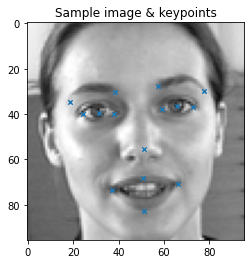

In [11]:
%%time

def load_images(image_data):
    images = []
    for idx, sample in image_data.iterrows():
        image = np.array(sample['Image'].split(' '), dtype=int)
        image = np.reshape(image, (96,96,1))
        images.append(image)
    images = np.array(images)/255.
    return images

def load_keypoints(keypoint_data):
    keypoint_data = keypoint_data.drop('Image',axis = 1)
    keypoint_features = []
    for idx, sample_keypoints in keypoint_data.iterrows():
        keypoint_features.append(sample_keypoints)
    keypoint_features = np.array(keypoint_features, dtype = 'float')
    return keypoint_features

clean_train_images = load_images(clean_train_data)
print("Shape of clean_train_images: {}".format(np.shape(clean_train_images)))
clean_train_keypoints = load_keypoints(clean_train_data)
print("Shape of clean_train_keypoints: {}".format(np.shape(clean_train_keypoints)))
test_images = load_images(test_data)
print("Shape of test_images: {}".format(np.shape(test_images)))

train_images = clean_train_images
train_keypoints = clean_train_keypoints
fig, axis = plt.subplots()
plot_sample(clean_train_images[sample_image_index], clean_train_keypoints[sample_image_index], axis, "Sample image & keypoints")

if include_unclean_data:
    unclean_train_images = load_images(unclean_train_data)
    print("Shape of unclean_train_images: {}".format(np.shape(unclean_train_images)))
    unclean_train_keypoints = load_keypoints(unclean_train_data)
    print("Shape of unclean_train_keypoints: {}\n".format(np.shape(unclean_train_keypoints)))
    train_images = np.concatenate((train_images, unclean_train_images))
    train_keypoints = np.concatenate((train_keypoints, unclean_train_keypoints))

データ補強のための水平フリップの実行

In [12]:
def left_right_flip(images, keypoints):
    flipped_keypoints = []
    flipped_images = np.flip(images, axis=2)   # Flip column-wise (axis=2)
    for idx, sample_keypoints in enumerate(keypoints):
        flipped_keypoints.append([96.-coor if idx%2==0 else coor for idx,coor in enumerate(sample_keypoints)])    # Subtract only X co-ordinates of keypoints from 96 for horizontal flipping
    return flipped_images, flipped_keypoints

if horizontal_flip:
    flipped_train_images, flipped_train_keypoints = left_right_flip(clean_train_images, clean_train_keypoints)
    print("Shape of flipped_train_images: {}".format(np.shape(flipped_train_images)))
    print("Shape of flipped_train_keypoints: {}".format(np.shape(flipped_train_keypoints)))
    train_images = np.concatenate((train_images, flipped_train_images))
    train_keypoints = np.concatenate((train_keypoints, flipped_train_keypoints))
    fig, axis = plt.subplots()
    plot_sample(flipped_train_images[sample_image_index], flipped_train_keypoints[sample_image_index], axis, "Horizontally Flipped") 

### ローテーション・オーギュメンテーションの実施

Augmenting for angles (in degrees): 
12  -12  
Shape of rotated_train_images: (4280, 96, 96, 1)
Shape of rotated_train_keypoints: (4280, 30)



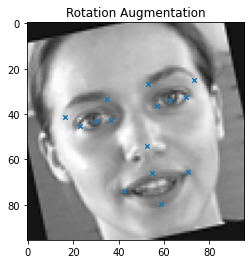

In [13]:
def rotate_augmentation(images, keypoints):
    rotated_images = []
    rotated_keypoints = []
    print("Augmenting for angles (in degrees): ")
    for angle in rotation_angles:    # 角度値のリストに対する回転の補強
        for angle in [angle,-angle]:
            print(f'{angle}', end='  ')
            M = cv2.getRotationMatrix2D((48,48), angle, 1.0)
            angle_rad = -angle*pi/180.     # 角度を度単位からラジアン単位で取得します（従来の回転と cv2 の画像回転では、時計回りと反時計回りの方向が異なるため、負の符号が付くことに注意）
            # train_imagesの場合
            for image in images:
                rotated_image = cv2.warpAffine(image, M, (96,96), flags=cv2.INTER_CUBIC)
                rotated_images.append(rotated_image)
            # For train_keypoints
            for keypoint in keypoints:
                rotated_keypoint = keypoint - 48.    # 画像寸法の中間値を減算する
                for idx in range(0,len(rotated_keypoint),2):
                    # https://in.mathworks.com/matlabcentral/answers/93554-how-can-i-rotate-a-set-of-points-in-a-plane-by-a-certain-angle-about-an-arbitrary-point
                    rotated_keypoint[idx] = rotated_keypoint[idx]*cos(angle_rad)-rotated_keypoint[idx+1]*sin(angle_rad)
                    rotated_keypoint[idx+1] = rotated_keypoint[idx]*sin(angle_rad)+rotated_keypoint[idx+1]*cos(angle_rad)
                rotated_keypoint += 48.   # 先に減算した値を加算する
                rotated_keypoints.append(rotated_keypoint)
            
    return np.reshape(rotated_images,(-1,96,96,1)), rotated_keypoints

if rotation_augmentation:
    rotated_train_images, rotated_train_keypoints = rotate_augmentation(clean_train_images, clean_train_keypoints)
    print("\nShape of rotated_train_images: {}".format(np.shape(rotated_train_images)))
    print("Shape of rotated_train_keypoints: {}\n".format(np.shape(rotated_train_keypoints)))
    train_images = np.concatenate((train_images, rotated_train_images))
    train_keypoints = np.concatenate((train_keypoints, rotated_train_keypoints))
    fig, axis = plt.subplots()
    plot_sample(rotated_train_images[sample_image_index], rotated_train_keypoints[sample_image_index], axis, "Rotation Augmentation")

### データ補強のための輝度変化の実行

Shape of altered_brightness_train_images: (4280, 96, 96, 1)
Shape of altered_brightness_train_keypoints: (4280, 30)


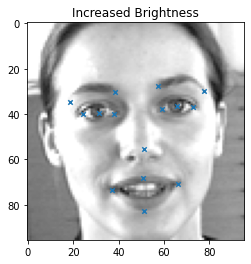

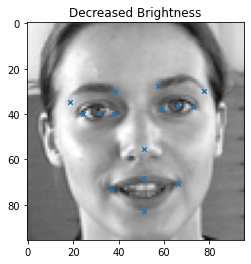

In [14]:
def alter_brightness(images, keypoints):
    altered_brightness_images = []
    inc_brightness_images = np.clip(images*1.2, 0.0, 1.0)    # 輝度を1.2倍にして、[-1,1]の範囲外の値をクリップする。
    dec_brightness_images = np.clip(images*0.6, 0.0, 1.0)    # 輝度を0.6倍に下げ、[-1,1]の範囲外の値をクリップする。
    altered_brightness_images.extend(inc_brightness_images)
    altered_brightness_images.extend(dec_brightness_images)
    return altered_brightness_images, np.concatenate((keypoints, keypoints))

if brightness_augmentation:
    altered_brightness_train_images, altered_brightness_train_keypoints = alter_brightness(clean_train_images, clean_train_keypoints)
    print(f"Shape of altered_brightness_train_images: {np.shape(altered_brightness_train_images)}")
    print(f"Shape of altered_brightness_train_keypoints: {np.shape(altered_brightness_train_keypoints)}")
    train_images = np.concatenate((train_images, altered_brightness_train_images))
    train_keypoints = np.concatenate((train_keypoints, altered_brightness_train_keypoints))
    fig, axis = plt.subplots()
    plot_sample(altered_brightness_train_images[sample_image_index], altered_brightness_train_keypoints[sample_image_index], axis, "Increased Brightness") 
    fig, axis = plt.subplots()
    plot_sample(altered_brightness_train_images[len(altered_brightness_train_images)//2+sample_image_index], altered_brightness_train_keypoints[len(altered_brightness_train_images)//2+sample_image_index], axis, "Decreased Brightness") 

### 水平・垂直方向のシフトを行う

Shape of shifted_train_images: (6350, 96, 96, 1)
Shape of shifted_train_keypoints: (6350, 30)


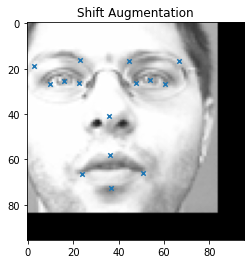

In [15]:
def shift_images(images, keypoints):
    shifted_images = []
    shifted_keypoints = []
    for shift in pixel_shifts:    # Augmenting over several pixel shift values
        for (shift_x,shift_y) in [(-shift,-shift),(-shift,shift),(shift,-shift),(shift,shift)]:
            M = np.float32([[1,0,shift_x],[0,1,shift_y]])
            for image, keypoint in zip(images, keypoints):
                shifted_image = cv2.warpAffine(image, M, (96,96), flags=cv2.INTER_CUBIC)
                shifted_keypoint = np.array([(point+shift_x) if idx%2==0 else (point+shift_y) for idx, point in enumerate(keypoint)])
                if np.all(0.0<shifted_keypoint) and np.all(shifted_keypoint<96.0):
                    shifted_images.append(shifted_image.reshape(96,96,1))
                    shifted_keypoints.append(shifted_keypoint)
    shifted_keypoints = np.clip(shifted_keypoints,0.0,96.0)
    return shifted_images, shifted_keypoints

if shift_augmentation:
    shifted_train_images, shifted_train_keypoints = shift_images(clean_train_images, clean_train_keypoints)
    print(f"Shape of shifted_train_images: {np.shape(shifted_train_images)}")
    print(f"Shape of shifted_train_keypoints: {np.shape(shifted_train_keypoints)}")
    train_images = np.concatenate((train_images, shifted_train_images))
    train_keypoints = np.concatenate((train_keypoints, shifted_train_keypoints))
    fig, axis = plt.subplots()
    plot_sample(shifted_train_images[sample_image_index], shifted_train_keypoints[sample_image_index], axis, "Shift Augmentation")

### データ補強のためのランダムノイズの付加

Shape of noisy_train_images: (2140, 96, 96, 1)


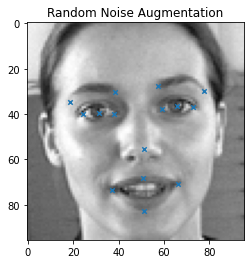

In [16]:
def add_noise(images):
    noisy_images = []
    for image in images:
        noisy_image = cv2.add(image, 0.008*np.random.randn(96,96,1))    # 入力画像にランダムな正規のノイズを加え、得られたノイズ画像を[-1,1]の間で切り取る。
        noisy_images.append(noisy_image.reshape(96,96,1))
    return noisy_images

if random_noise_augmentation:
    noisy_train_images = add_noise(clean_train_images)
    print(f"Shape of noisy_train_images: {np.shape(noisy_train_images)}")
    train_images = np.concatenate((train_images, noisy_train_images))
    train_keypoints = np.concatenate((train_keypoints, clean_train_keypoints))
    fig, axis = plt.subplots()
    plot_sample(noisy_train_images[sample_image_index], clean_train_keypoints[sample_image_index], axis, "Random Noise Augmentation")

### トレイン画像と対応するKeypointの可視化

最終的なtrain_imagesの形状: (26239, 96, 96, 1)
最終的なtrain_keypointsの形状: (26239, 30)

 クリーントレイン・データ 


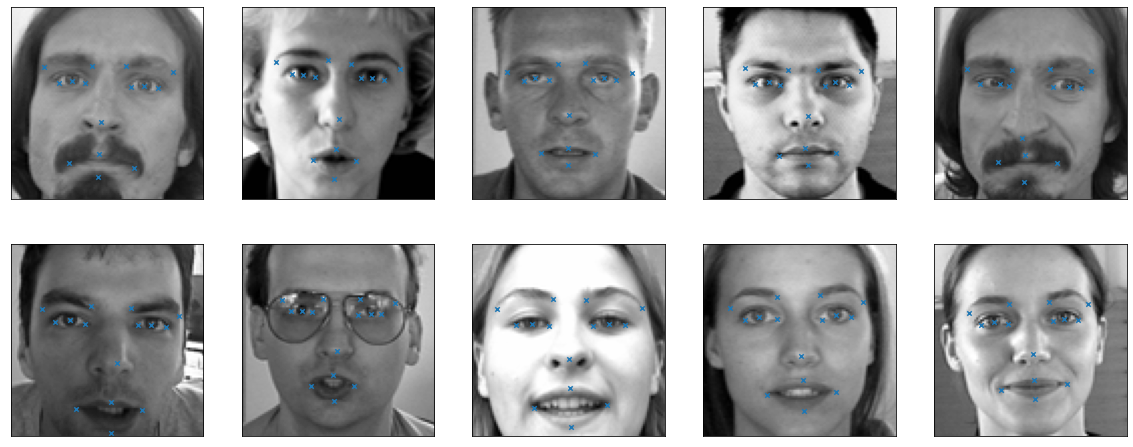

アンクリーンなトレインデータ 


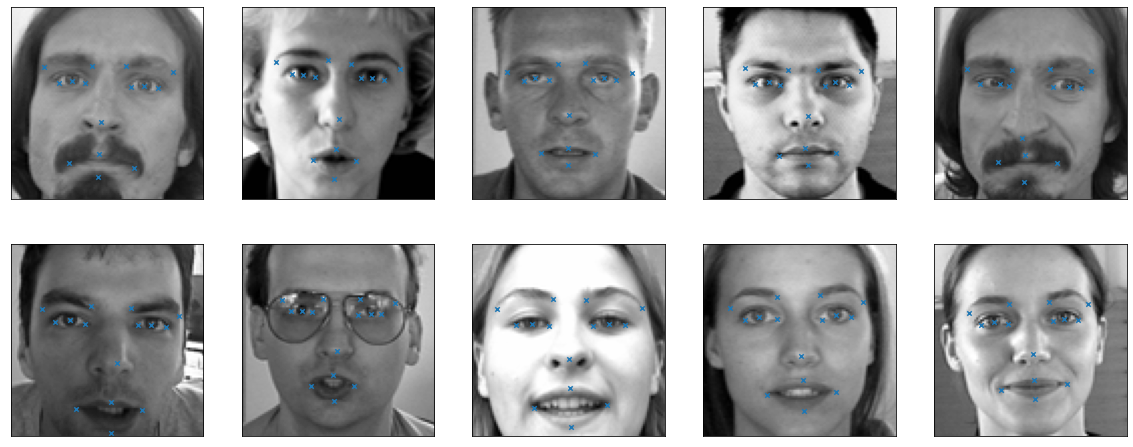

ローテーション・オーギュメンテーション: 


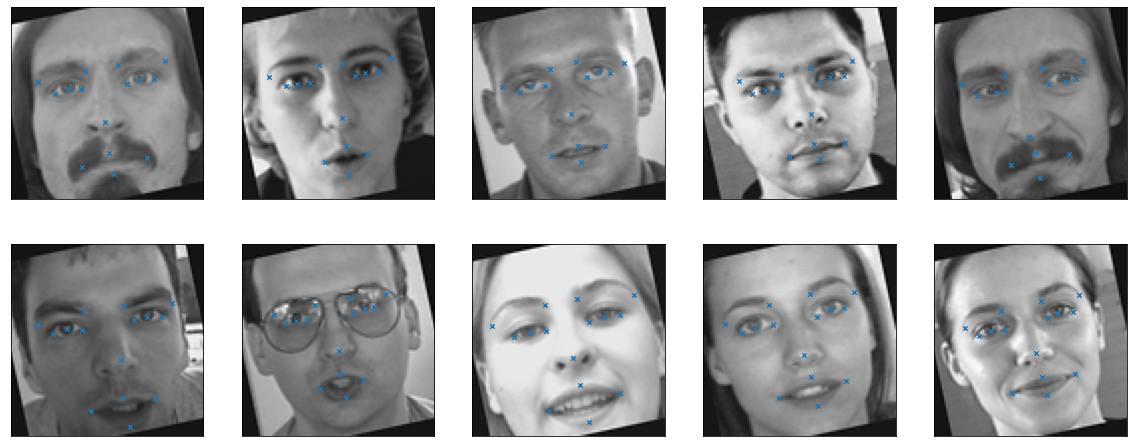

輝度補強: 


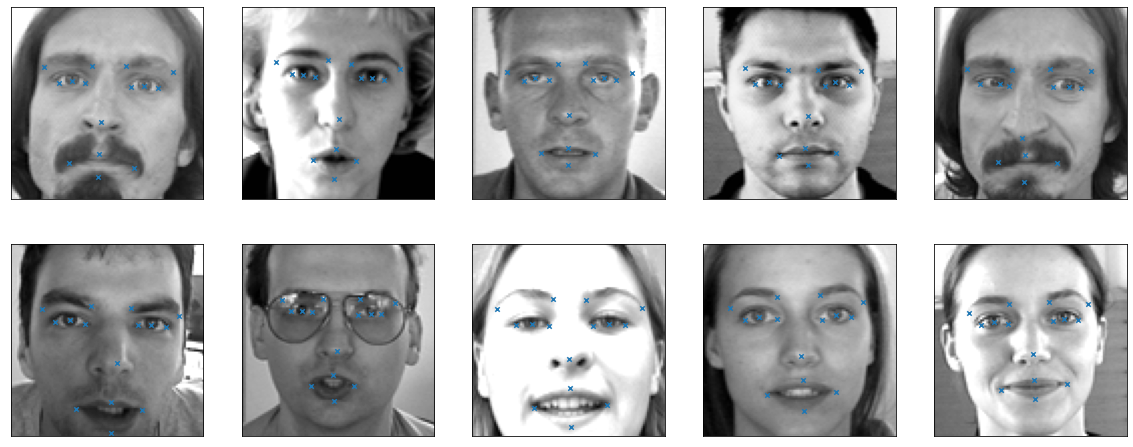

シフト補強: 


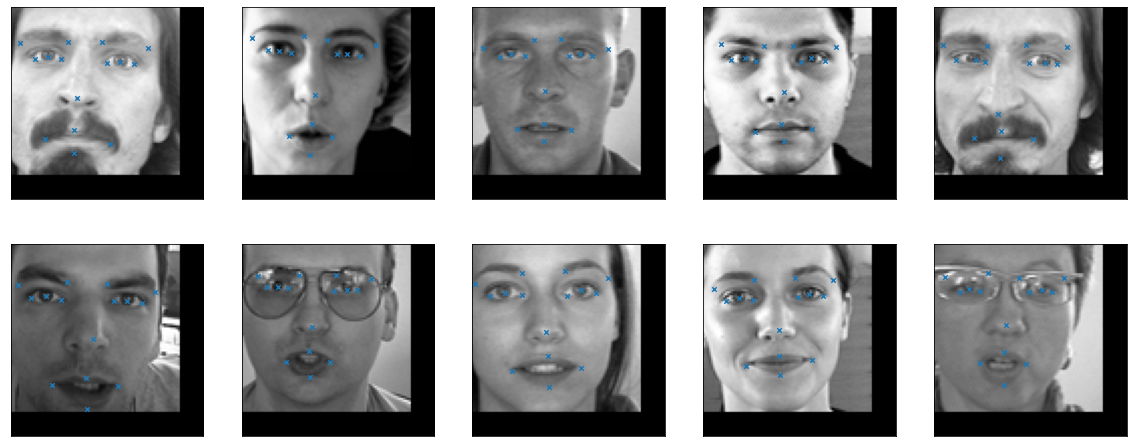

ランダムノイズの補強: 


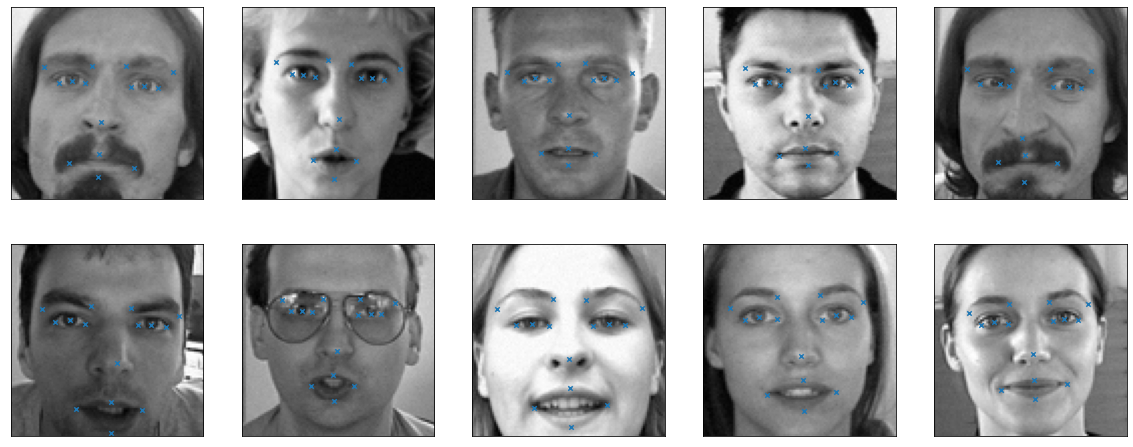

In [17]:
print("最終的なtrain_imagesの形状: {}".format(np.shape(train_images)))
print("最終的なtrain_keypointsの形状: {}".format(np.shape(train_keypoints)))

print("\n クリーントレイン・データ ")
fig = plt.figure(figsize=(20,8))
for i in range(10):
    axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
    plot_sample(clean_train_images[i], clean_train_keypoints[i], axis, "")
plt.show()

if include_unclean_data:
    print("アンクリーンなトレインデータ ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(unclean_train_images[i], unclean_train_keypoints[i], axis, "")
    plt.show()

if horizontal_flip:
    print("ホリゾンタル フリップ オーギュメンテーション: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(flipped_train_images[i], flipped_train_keypoints[i], axis, "")
    plt.show()

if rotation_augmentation:
    print("ローテーション・オーギュメンテーション: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(rotated_train_images[i], rotated_train_keypoints[i], axis, "")
    plt.show()
    
if brightness_augmentation:
    print("輝度補強: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(altered_brightness_train_images[i], altered_brightness_train_keypoints[i], axis, "")
    plt.show()

if shift_augmentation:
    print("シフト補強: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(shifted_train_images[i], shifted_train_keypoints[i], axis, "")
    plt.show()
    
if random_noise_augmentation:
    print("ランダムノイズの補強: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(noisy_train_images[i], clean_train_keypoints[i], axis, "")
    plt.show()

### モデルの構築

In [18]:
model = Sequential()

# 入力寸法: (None, 96, 96, 1)
model.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=(96,96,1)))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
# 入力寸法: (None, 96, 96, 32)
model.add(Convolution2D(32, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# 入力寸法: (None, 48, 48, 32)
model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
# 入力寸法: (None, 48, 48, 64)
model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# 入力寸法: (None, 24, 24, 64)
model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
# 入力寸法: (None, 24, 24, 96)
model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# 入力寸法: (None, 12, 12, 96)
model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
# 入力寸法: (None, 12, 12, 128)
model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# 入力寸法: (None, 6, 6, 128)
model.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
# 入力寸法: (None, 6, 6, 256)
model.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# 入力寸法: (None, 3, 3, 256)
model.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
# 入力寸法: (None, 3, 3, 512)
model.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

# 入力寸法: (None, 3, 3, 512)
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(30))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 32)        288       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 96, 96, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 32)        9216      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0

### モデルのトレーニング

In [19]:
%%time

# 事前に学習したモデルをロードする（存在する場合）
if os.path.exists('best_model.hdf5'):
    model = load_model('best_model.hdf5')

# 必要なコールバックの定義
checkpointer = ModelCheckpoint(filepath = 'best_model.hdf5', monitor='val_mae', verbose=1, save_best_only=True, mode='min')

# モデルをコンパイルする
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'acc'])

history = model.fit(train_images, train_keypoints, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_split=0.05, callbacks=[checkpointer])

Epoch 1/80
390/390 [==============================] - 27s 24ms/step - loss: 136.7538 - mae: 6.6886 - acc: 0.4334 - val_loss: 17.4413 - val_mae: 3.1291 - val_acc: 0.3064

Epoch 00001: val_mae improved from inf to 3.12907, saving model to best_model.hdf5
Epoch 2/80
390/390 [==============================] - 8s 22ms/step - loss: 13.7863 - mae: 2.8710 - acc: 0.6539 - val_loss: 10.2570 - val_mae: 2.5608 - val_acc: 0.6189

Epoch 00002: val_mae improved from 3.12907 to 2.56084, saving model to best_model.hdf5
Epoch 3/80
390/390 [==============================] - 9s 22ms/step - loss: 11.2342 - mae: 2.5594 - acc: 0.6979 - val_loss: 4.4419 - val_mae: 1.5810 - val_acc: 0.6806

Epoch 00003: val_mae improved from 2.56084 to 1.58103, saving model to best_model.hdf5
Epoch 4/80
390/390 [==============================] - 9s 22ms/step - loss: 8.6409 - mae: 2.2461 - acc: 0.7411 - val_loss: 5.7285 - val_mae: 1.9398 - val_acc: 0.7454

Epoch 00004: val_mae did not improve from 1.58103
Epoch 5/80
390/390 [==

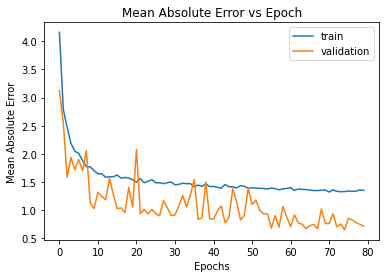

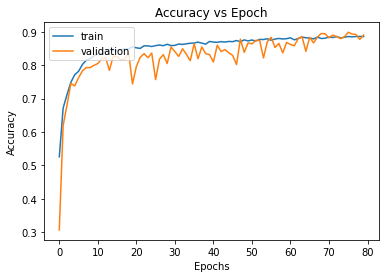

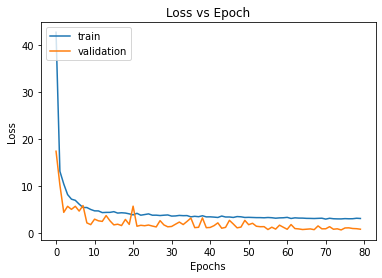

In [20]:
# 履歴を平均絶対誤差にまとめる
try:
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('Mean Absolute Error vs Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
    # 履歴を正確にまとめる
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Accuracy vs Epoch')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # 損切りするための歴史をまとめる
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss vs Epoch')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
except:
    print("グラフのプロットに使用するメトリクスの1つが欠落しています! model.compile()の `metrics` 引数を参照してください。.")

完全なデータセットにモデルを当てはめる

In [21]:
%%time

# ModelCheckpointコールバックを修正し、（最適な検証前のモデルではなく）最適なトレーニング前のモデルをディスクに保存するようにしました。
checkpointer = ModelCheckpoint(filepath = 'best_model.hdf5', monitor='mae', verbose=1, save_best_only=True, mode='min')
model.fit(train_images, train_keypoints, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, callbacks=[checkpointer])

Epoch 1/80
410/410 [==============================] - 9s 22ms/step - loss: 2.9862 - mae: 1.3147 - acc: 0.8884

Epoch 00001: mae improved from inf to 1.31472, saving model to best_model.hdf5
Epoch 2/80
410/410 [==============================] - 9s 21ms/step - loss: 2.9790 - mae: 1.3142 - acc: 0.8863

Epoch 00002: mae improved from 1.31472 to 1.31417, saving model to best_model.hdf5
Epoch 3/80
410/410 [==============================] - 9s 21ms/step - loss: 2.9979 - mae: 1.3185 - acc: 0.8846

Epoch 00003: mae did not improve from 1.31417
Epoch 4/80
410/410 [==============================] - 9s 21ms/step - loss: 2.9714 - mae: 1.3133 - acc: 0.8862

Epoch 00004: mae improved from 1.31417 to 1.31326, saving model to best_model.hdf5
Epoch 5/80
410/410 [==============================] - 9s 21ms/step - loss: 2.9625 - mae: 1.3084 - acc: 0.8853

Epoch 00005: mae improved from 1.31326 to 1.30839, saving model to best_model.hdf5
Epoch 6/80
410/410 [==============================] - 9s 21ms/step - lo

### テストセットでの予測

In [22]:
%%time
 
model = load_model('best_model.hdf5')
test_preds = model.predict(test_images)

CPU times: user 1.13 s, sys: 174 ms, total: 1.3 s
Wall time: 1.2 s


### テスト予測の可視化

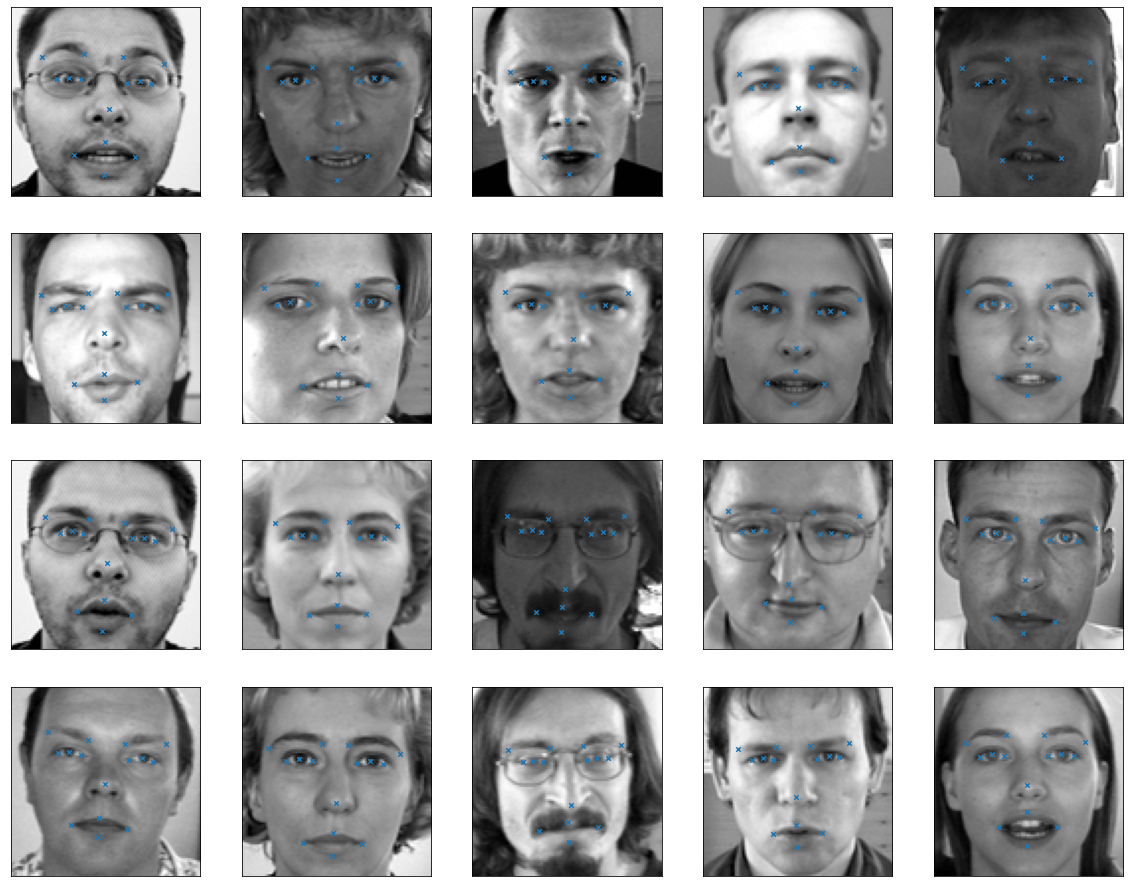

In [23]:
fig = plt.figure(figsize=(20,16))
for i in range(20):
    axis = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
    plot_sample(test_images[i], test_preds[i], axis, "")
plt.show()

### 提出ファイルの作成

In [24]:
feature_names = list(idlookup_data['FeatureName'])
image_ids = list(idlookup_data['ImageId']-1)
row_ids = list(idlookup_data['RowId'])

feature_list = []
for feature in feature_names:
    feature_list.append(feature_names.index(feature))
    
predictions = []
for x,y in zip(image_ids, feature_list):
    predictions.append(test_preds[x][y])
    
row_ids = pd.Series(row_ids, name = 'RowId')
locations = pd.Series(predictions, name = 'Location')
locations = locations.clip(0.0,96.0)
submission_result = pd.concat([row_ids,locations],axis = 1)
submission_result.to_csv('submission.csv',index = False)